In [1]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import datetime
import haversine as hs
from sklearn.metrics import r2_score
import folium
import geopandas 
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data Preparation

In [2]:
data=pd.read_csv('uber.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
5,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1
6,2014-10-12 07:04:00.0000002,24.5,2014-10-12 07:04:00 UTC,-73.961447,40.693965,-73.871195,40.774297,5
7,2012-12-11 13:52:00.00000029,2.5,2012-12-11 13:52:00 UTC,0.000000,0.000000,0.000000,0.000000,1
8,2012-02-17 09:32:00.00000043,9.7,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1
9,2012-03-29 19:06:00.000000273,12.5,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,40.775012,1


In [3]:
data.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [4]:
#Drop null data
data.dropna(inplace=True)

In [5]:
#Drop Key column
data.drop('key', axis=1, inplace=True)
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [6]:
#We see that some latitudes and longitudes are unrealistic with values lower than -180, so we delete those entries:
data=data[(abs(data.pickup_longitude)<=180)& (abs(data.pickup_latitude)<=180)&(abs(data.dropoff_longitude)<=180)& (abs(data.dropoff_latitude)<=180)]

In [7]:
#Calculating trip distances using haversine formula:
distance=[]
for x in zip(zip(data.pickup_latitude , data.pickup_longitude), zip(data.dropoff_latitude , data.dropoff_longitude)):
    distance.append(hs.haversine(x[0], x[1]))
data['distance']=distance

In [8]:
data.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683325
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457593
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036384
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661686
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475456


In [9]:
#Prepare time data with datetime 
data['pickup_datetime']=data['pickup_datetime'].apply(pd.to_datetime)

In [10]:
#Create diffrent variable for hours, days, months and years
data['Years']=data.pickup_datetime.apply(lambda x:x.year)
data['Months']=data.pickup_datetime.apply(lambda x:x.month)
data['Days']=data.pickup_datetime.apply(lambda x:x.day)
data['Hours']=data.pickup_datetime.apply(lambda x:x.round("H").hour)

In [11]:
data.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,Years,Months,Days,Hours
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683325,2015,5,7,20
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457593,2009,7,17,20
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036384,2009,8,24,22
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661686,2009,6,26,8
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475456,2014,8,28,18


In [12]:
#Initial regression model:
reg = linear_model.LinearRegression()
y=data['fare_amount']
X=data.iloc[:, 7:]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.33, random_state=42)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
yhat=reg.predict(X_test)
MSE1=mean_squared_error(yhat, y_test)
print('MSE: {}'.format(MSE1))

MSE: 93.07775910427746


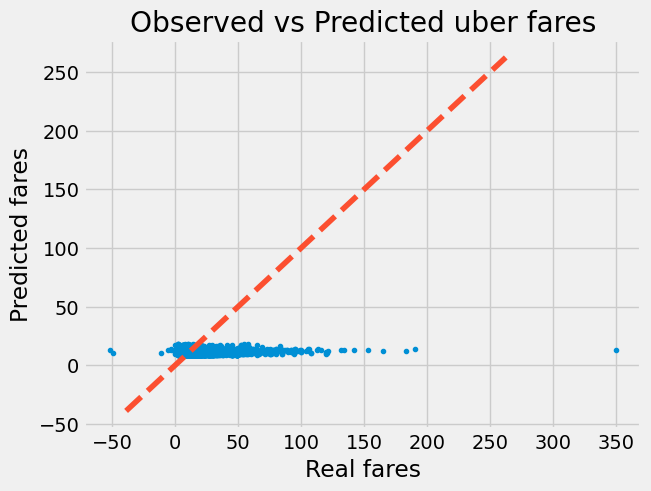

In [13]:
plt.style.use('fivethirtyeight')
plt.plot( y_test,yhat, '.')
line=[0.75*y_test.min(), 0.75*y_test.max()]
plt.plot(line, line , '--')
plt.xlabel('Real fares')
plt.ylabel('Predicted fares')
plt.title('Observed vs Predicted uber fares')
plt.show();

In [14]:
#We see that the model performed poorly on raw data, let's fix that!

# Exploratory Data Analysis

In [16]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,Years,Months,Days,Hours
count,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000
mean,11.359849,-72.501786,39.917937,-72.511608,39.922031,1.684544,20.560358,2011.742463,6.281783,15.704736,13.420237
std,9.901868,10.449955,6.130412,10.412192,6.117669,1.385999,379.621262,1.856438,3.438957,8.687469,6.681808
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992064,40.734793,-73.991407,40.733823,1.000000,1.215169,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2.120828,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,3.874784,2013.000000,9.000000,23.000000,19.000000
max,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,8782.910738,2015.000000,12.000000,31.000000,23.000000


## Analyzing variables: 1- Passenger count

C:\Users\youss\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


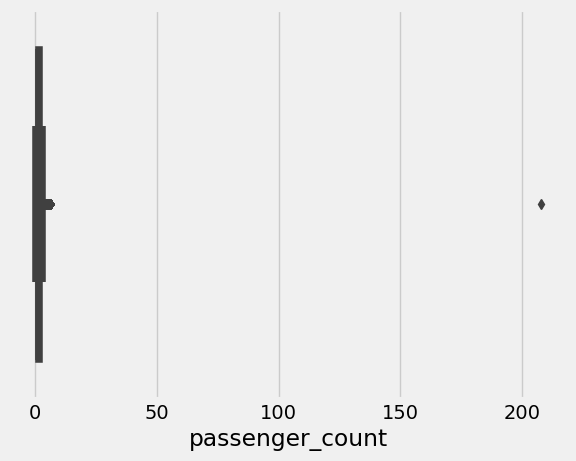

In [17]:
sns.boxplot(data.passenger_count);

C:\Users\youss\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


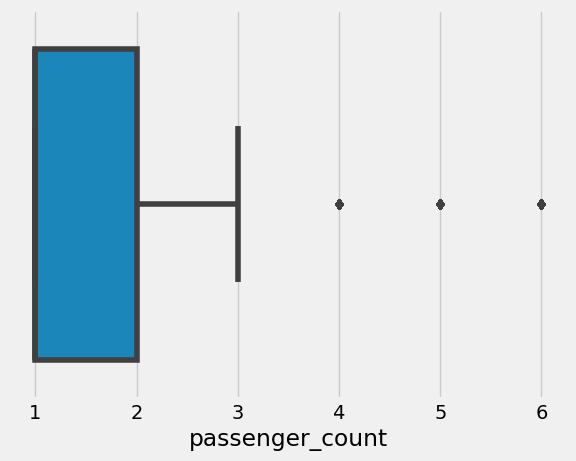

In [18]:
# We know thatuber usually take a maximum of 6 passengers at once:
data=data[(data.passenger_count<7) * (data.passenger_count>0)]
sns.boxplot(data['passenger_count']);

## Analyzing variables: 2- Latitudes and Longitudes

C:\Users\youss\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


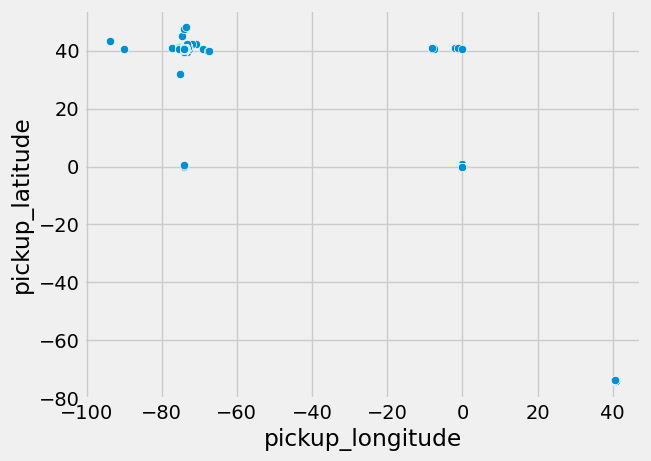

In [19]:
sns.scatterplot(data.pickup_longitude, data.pickup_latitude);

In [20]:
#We delete any trip that resulted in 0 distance:
data=data[data.distance>0]

C:\Users\youss\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='distance', ylabel='Density'>

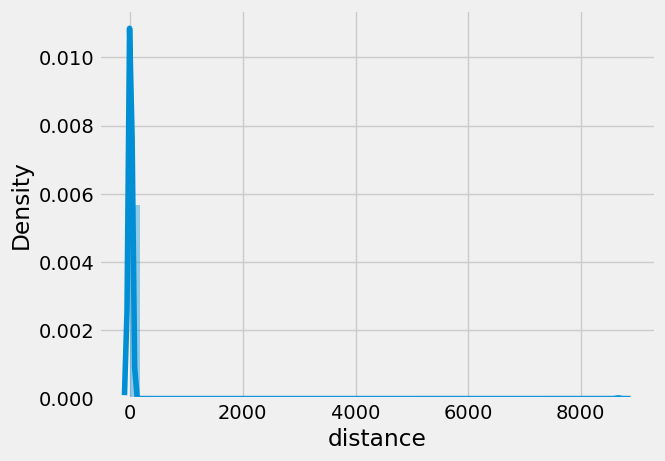

In [21]:
sns.distplot(data.distance)

C:\Users\youss\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


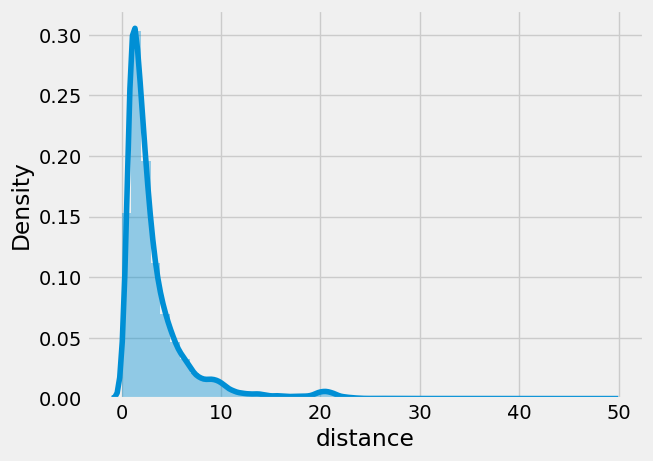

In [22]:
#We see that most of trips are less than 50 kms:
data=data[data.distance<50]
sns.distplot(data.distance);

C:\Users\youss\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


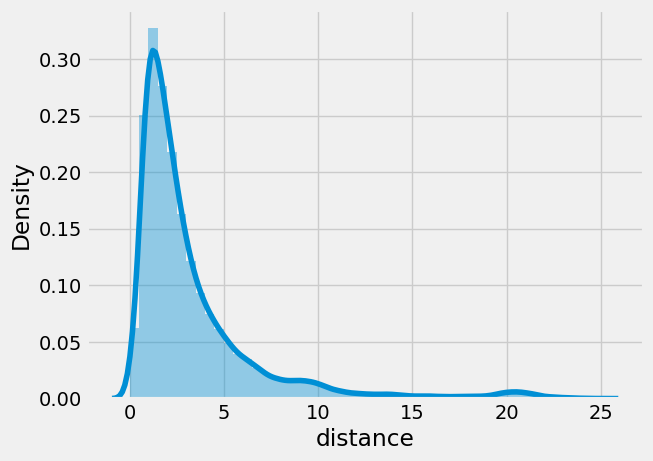

In [23]:
#And the vast majority are less than 25 kms:
data=data[data.distance<25]
sns.distplot(data.distance);

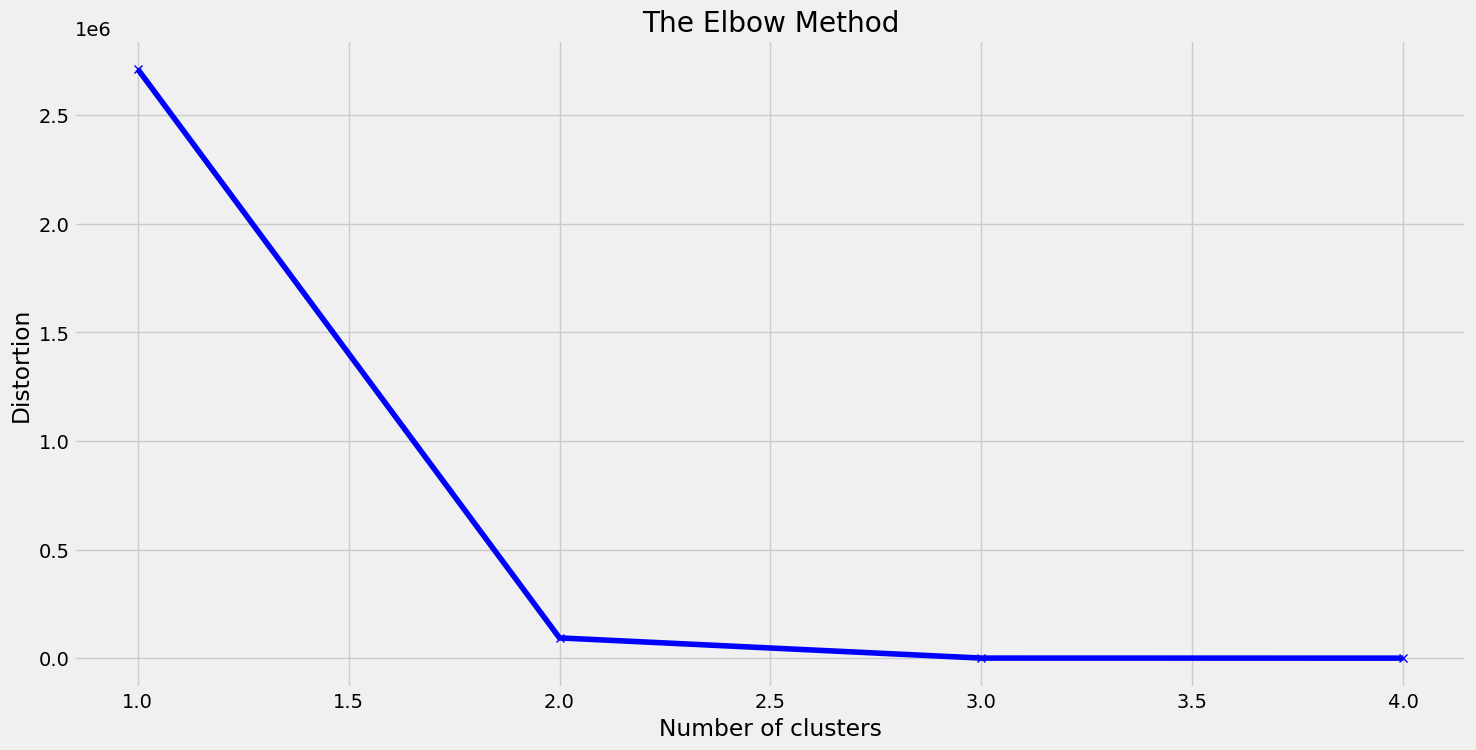

In [24]:
#Identify locations of trips using clustering by KMeans
distortions = []
K = range(1,5)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data[['pickup_latitude','pickup_longitude']].values)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()
#we see that k=2 is optimal

In [25]:
#Create a new variable locations
model = KMeans(n_clusters=2)
data['Locations']=model.fit_predict(data[['pickup_latitude','pickup_longitude']].values)

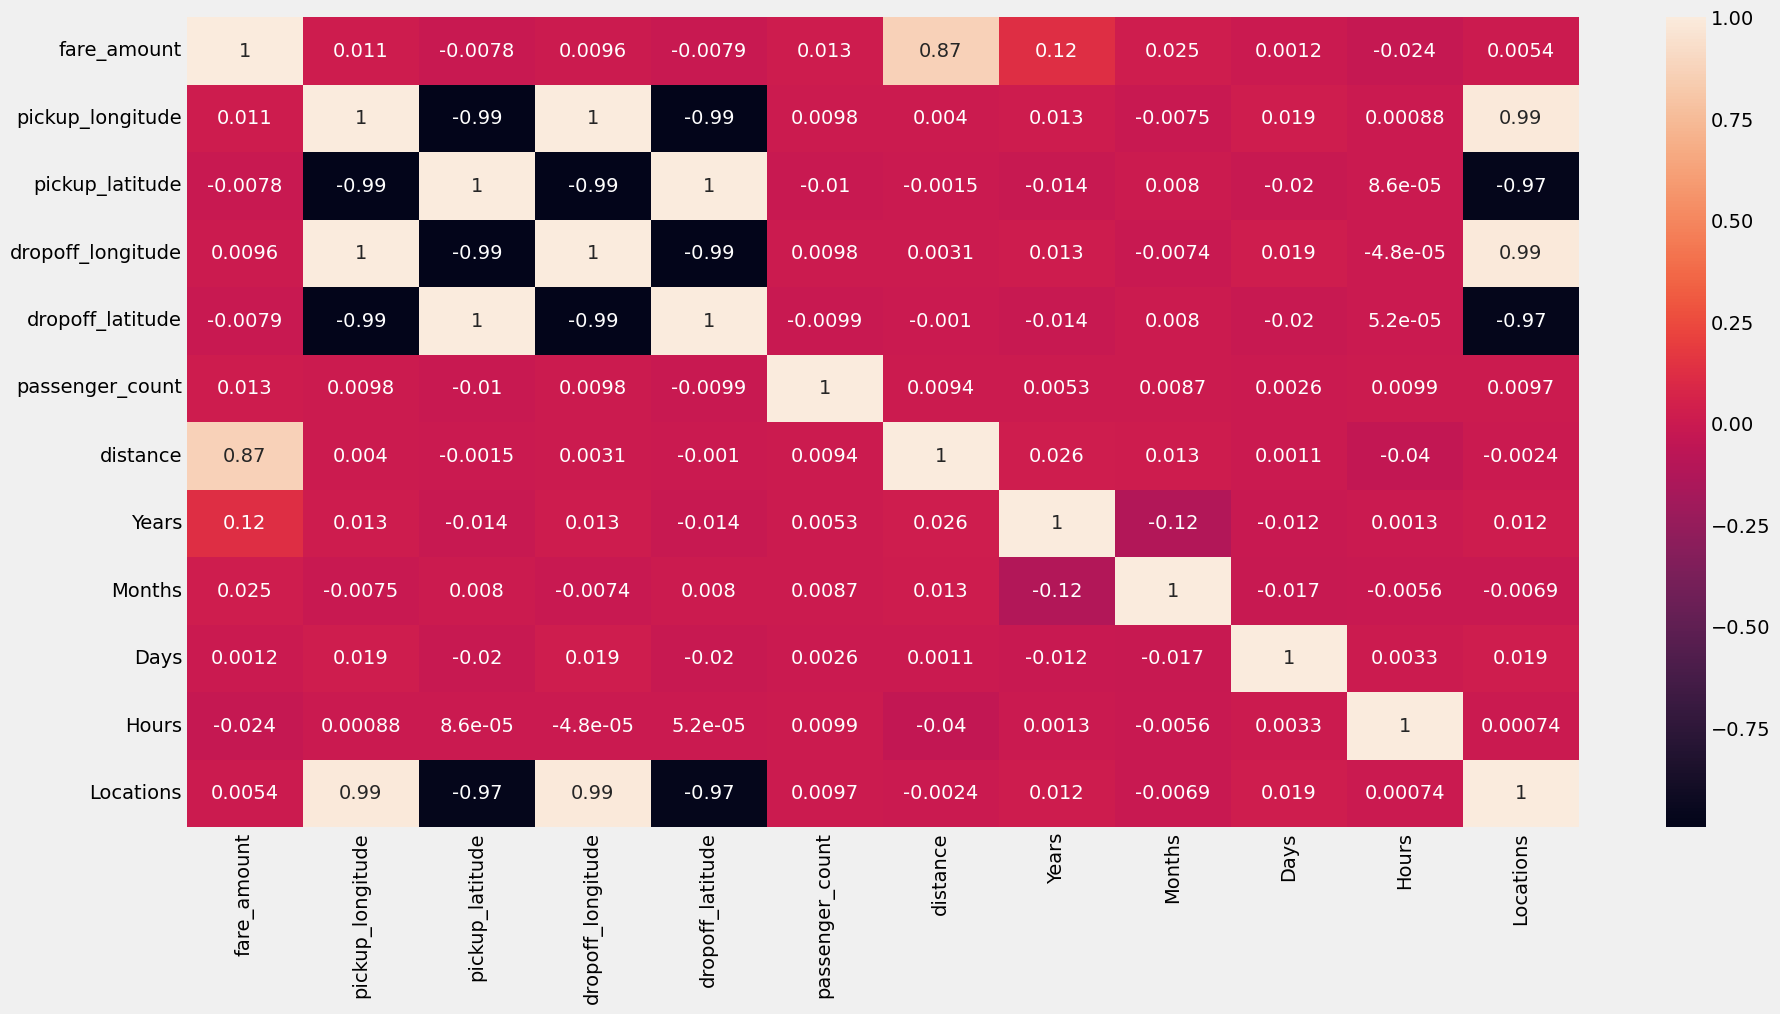

In [26]:
fig= plt.gcf()
fig.set_size_inches(20, 10)
sns.heatmap(data.corr(), annot=True);

## Analyzing variables: 3- Date & time

In [27]:
#We see that distance and years have high correlation with the fare amount so we choose to analyze only the latest year of data (2015)
data=data[data.Years==2015]
data.drop('Years', axis=1, inplace=True)

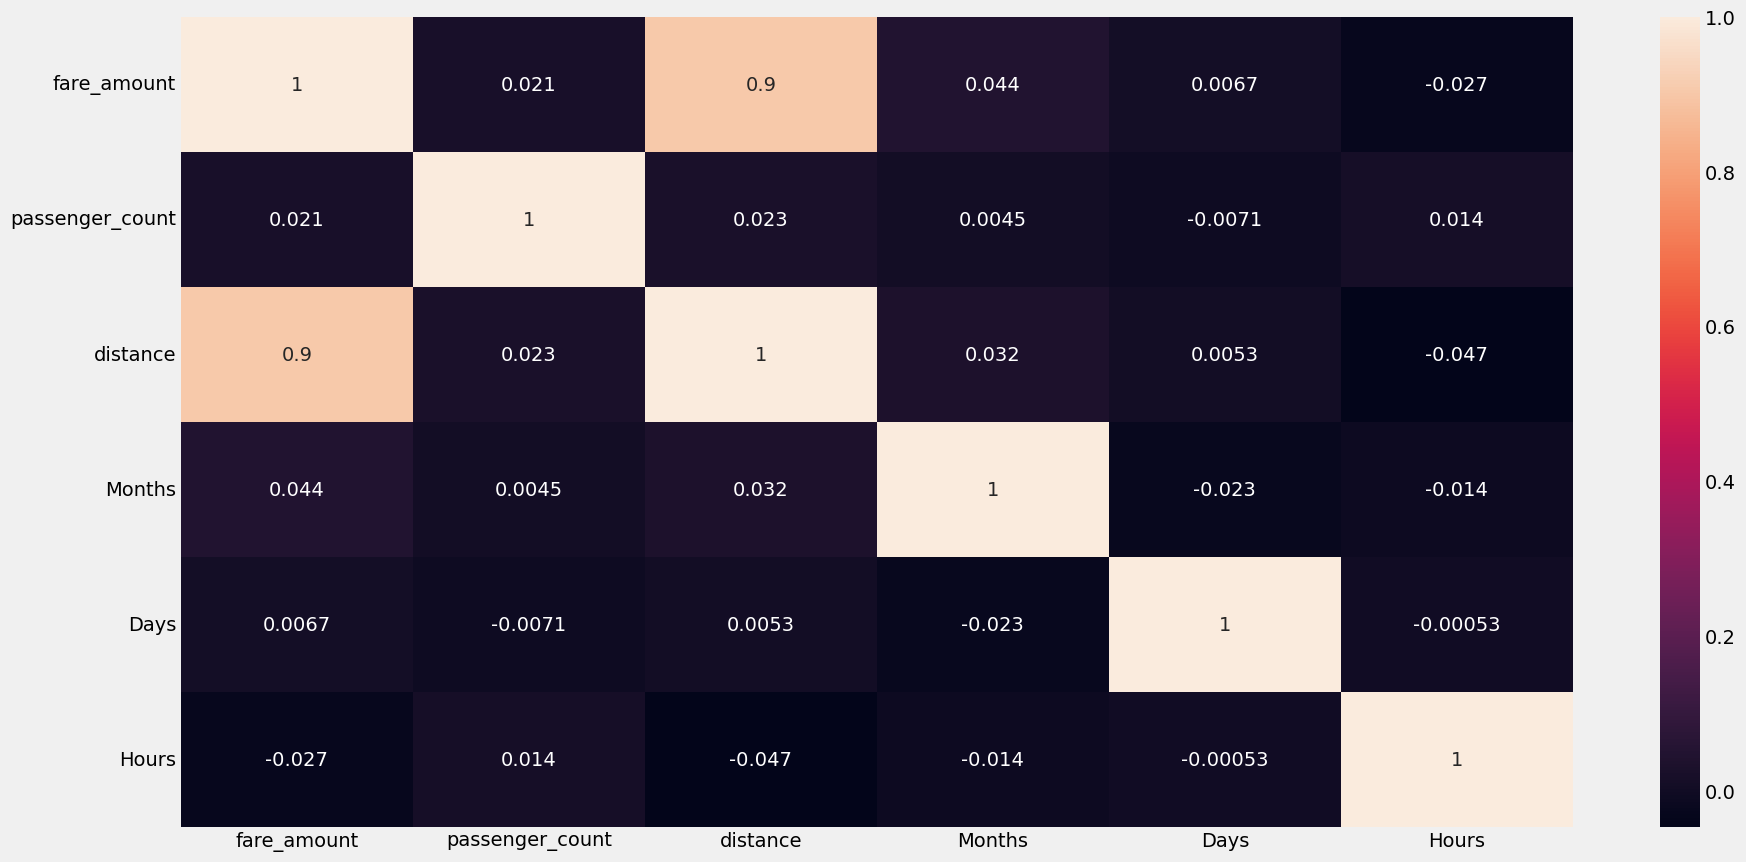

In [28]:
#We drop unused columns
data.drop(data.columns[1:6], axis=1, inplace=True)
data.drop('Locations', axis=1, inplace=True)
fig= plt.gcf()
fig.set_size_inches(20, 10)
sns.heatmap(data.corr(), annot=True);

# Linear Regression

In [29]:
#Creating the linear regression
reg = linear_model.LinearRegression()
df=data
y=df['fare_amount']
X=df.iloc[:, 1:]

In [30]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.33, random_state=42)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
yhat=reg.predict(X_test)
MSE2=mean_squared_error(yhat, y_test)
print('MSE: {}'.format(MSE2))

MSE: 22.261818611882514


In [32]:
print('MSE improved by {value:.2f}%'.format(value=(MSE1-MSE2)/MSE1*100))

MSE improved by 76.08%


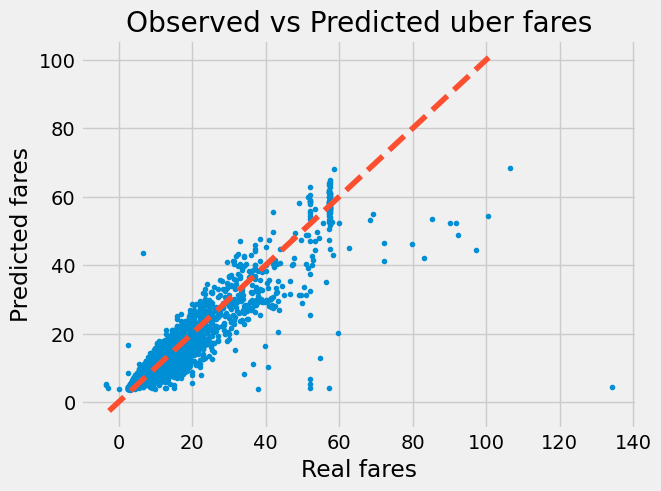

In [33]:
plt.style.use('fivethirtyeight')
plt.plot( y_test,yhat, '.')
line=[0.75*y_test.min(), 0.75*y_test.max()]
plt.plot(line, line , '--')
plt.xlabel('Real fares')
plt.ylabel('Predicted fares')
plt.title('Observed vs Predicted uber fares')
plt.show();